## Import packages

In [1]:
import os
import graphviz
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from sklearn import tree

## Import data

In [2]:
file_input = os.path.join(os.getcwd() + os.sep, 'output_data', '03_topics_modeling_final.csv')
df = pd.read_csv(file_input, encoding='utf-8')
df = df.set_index('case_id', drop=True)
df['date'] = df['date'].apply(lambda x: re.compile('(\d+\-\d+\-\d+)').search(str(x)).group(1) 
                 if re.compile('(\d+\-\d+\-\d+)').search(str(x)) else "")
df = df[['cause_label','date','occupation','body_parts','activity','is_fatal']]
df.head()

,cause_label,date,occupation,body_parts,activity,is_fatal
case_id,,,,,,
201079928,Exposure to chemicals,13-11-13,"construction_worker, driver","foot, back, groin, abdomen, leg",Employee Is Burned By Forklift Radiator Fluid,False
202561825,Struck by moving object,30-08-13,construction_worker,abdomen,Employee Falls From Flatbed Trailer And Later...,True
200361855,Struck by moving object,27-08-13,"construction_worker, power_line_worker",abdomen,Two Workers Are Struck By Motor Vehicle And O...,True
200361863,Caught in/between Objects,26-08-13,construction_worker,"face, back, head, torso, abdomen, leg",Employee Is Struck By Bales Of Wire And Killed,True
201079324,Exposure to chemicals,14-07-13,"driver, operator","shoulder, abdomen, leg",Employee Is Splashed With Hot Water And Is Bu...,False


## Classification
Fatality prediction using features: "occupation, body_parts, cause_label"

In [3]:
# use features "occupation, body_parts, cause_label" to predict fatality
df2 = df[['cause_label', 'occupation', 'body_parts', 'is_fatal']]
df2 = df2.reset_index(drop=True)
df3 = df2[df2['occupation'].str.isdigit().notnull() & df2['body_parts'].str.isdigit().notnull()]
df3.head()

,cause_label,occupation,body_parts,is_fatal
0,Exposure to chemicals,"construction_worker, driver","foot, back, groin, abdomen, leg",False
1,Struck by moving object,construction_worker,abdomen,True
2,Struck by moving object,"construction_worker, power_line_worker",abdomen,True
3,Caught in/between Objects,construction_worker,"face, back, head, torso, abdomen, leg",True
4,Exposure to chemicals,"driver, operator","shoulder, abdomen, leg",False


In [4]:
# re-sampling on imbalanced dataset
def under_sampling(df):
    
    print("Before re-sampling:\n%s" % df.is_fatal.value_counts())
    df_class0 = df[df.is_fatal==False]
    df_class1 = df[df.is_fatal==True]
    
    minority = min(df_class0.shape[0],df_class1.shape[0])
    df_new_class0 = resample(df_class0, replace=False, n_samples=minority, random_state=120)
    df_new_class1 = resample(df_class1, replace=False, n_samples=minority, random_state=120)
    df_new = pd.concat([df_new_class1, df_new_class0])
    df_new = df_new.reset_index(drop=True)
    
    print("After re-sampling:\n%s" % df_new.is_fatal.value_counts())
    return df_new
#
df4 = under_sampling(df3)

Before re-sampling:
False    4620
True     1844
Name: is_fatal, dtype: int64
After re-sampling:
True     1844
False    1844
Name: is_fatal, dtype: int64


In [5]:
# flattern "occupation, body_parts"
def create_dtm(data):
    
    df = data.copy()
    df['occupation'] = df['occupation'].apply(lambda x: "occupation_" + str(x))
    df['occupation'] = df['occupation'].apply(lambda x: str(x).replace(", ", " occupation_"))
    df['body_parts'] = df['body_parts'].apply(lambda x: "body_" + str(x))
    df['body_parts'] = df['body_parts'].apply(lambda x: str(x).replace(", ", " body_"))
    df['occupation_body'] = df['occupation'].map(str) + " " + df['body_parts'].map(str)
    
    count_vect = CountVectorizer( )
    X_counts = count_vect.fit_transform(df.occupation_body)
    dtm = pd.DataFrame(X_counts.toarray().transpose(), index = count_vect.get_feature_names())
    #dtm = dtm.transpose()
    
    dtm_ = pd.concat([df, dtm.transpose()], axis=1)
    dtm_ = dtm_.reset_index(drop=True)
    del dtm_['occupation']
    del dtm_['body_parts']
    del dtm_['occupation_body']
    
    return dtm_
#
df_final = create_dtm(df4)
df_final.to_csv("04_classificaiton.csv",sep=",",index=False)
df_final.head()

,cause_label,is_fatal,body_abdomen,body_ankle,body_arch,body_arm,body_back,body_bone,body_brain,body_breast,...,occupation_sole_proprietor,occupation_store_owner,occupation_technician,occupation_tile_setter,occupation_timber_faller,occupation_transformer,occupation_vet,occupation_volunteer,occupation_welder,occupation_zoo_keeper
0,Fall from height,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fall from height,True,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Struck by moving object,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Exposure to chemicals,True,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Exposure to chemicals,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# categorize body_parts into 4 groups: upper_limb, lower_limbm, body, and head.
def merge_columns(data, list_columns, new_column):
    df = data.copy()
    for j in range(df.shape[0]):
        injured = 0
        for i in list_columns:
            injured += int(df[i][j])
        df.loc[df.index[j], new_column] = "1" if injured > 0 else "0"
    for i in list_columns:
        del df[i]
        
    return df
#
list_upper_limb = ['body_arm','body_elbow','body_finger','body_forearm',
                   'body_hand','body_knuckle','body_thumb','body_wrist',]
list_lower_limb = ['body_ankle','body_buttock','body_calf','body_femur',
                   'body_foot','body_groin','body_heel','body_knee',
                   'body_leg','body_pelvis','body_thigh','body_toe']
list_body = ['body_abdomen','body_arch','body_back','body_bone',
             'body_breast','body_chest','body_collarbone','body_heart',
             'body_hip','body_lung','body_multi_organs','body_nerve',
             'body_shoulder','body_spleen','body_stomach','body_tissue',
             'body_torso','body_vessel','body_waist',]
list_head = ['body_brain','body_cheek','body_chin','body_eye',
             'body_eyebrow','body_eyelid','body_face','body_forehead',
             'body_gum','body_head','body_jaw','body_lip',
             'body_mouth','body_neck','body_teeth','body_throat']
#
df_merge = merge_columns(df_final, list_upper_limb, "upper_limb")
df_merge = merge_columns(df_merge, list_lower_limb, "lower_limb")
df_merge = merge_columns(df_merge, list_body, "body")
df_merge = merge_columns(df_merge, list_head, "head")
#
df_merge.to_csv("04_classificaiton_categorized_body_parts.csv",sep=",",index=False)
df_merge.head()

,cause_label,is_fatal,occupation_anesthesiologist,occupation_aquatic_worker,occupation_carpenter,occupation_cleaner,occupation_communications_worker,occupation_construction_worker,occupation_contractor,occupation_cook,...,occupation_timber_faller,occupation_transformer,occupation_vet,occupation_volunteer,occupation_welder,occupation_zoo_keeper,upper_limb,lower_limb,body,head
0,Fall from height,True,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Fall from height,True,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,Struck by moving object,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Exposure to chemicals,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Exposure to chemicals,True,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# encode the cause label to train data using sklean decision tree
def encode_cause_label(data):
    df = data.copy()
    all_causes = list(df.cause_label.unique())
    for i,cause in enumerate(all_causes):
        print("Encode Cause Label: %s -> %d" % (cause, i))
        df.loc[df.cause_label == cause, 'cause_label'] = i
    return df
#
#df_clf = encode_cause_label(df_merge)
df_clf = encode_cause_label(df_final)
df_clf.head()

Encode Cause Label: Fall from height -> 0
Encode Cause Label: Struck by moving object -> 1
Encode Cause Label: Exposure to chemicals -> 2
Encode Cause Label: Collapse of Objects -> 3
Encode Cause Label: Trenching and Excavation -> 4
Encode Cause Label: Operating Machinery -> 5
Encode Cause Label: Caught in/between Objects -> 6
Encode Cause Label: Electrocution -> 7
Encode Cause Label: Fire / Explosion -> 8
Encode Cause Label: Other -> 9


,cause_label,is_fatal,body_abdomen,body_ankle,body_arch,body_arm,body_back,body_bone,body_brain,body_breast,...,occupation_sole_proprietor,occupation_store_owner,occupation_technician,occupation_tile_setter,occupation_timber_faller,occupation_transformer,occupation_vet,occupation_volunteer,occupation_welder,occupation_zoo_keeper
0,0,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,True,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,True,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#split the data into training and testing
X = df_clf.loc[:, df_clf.columns != 'is_fatal']
y = df_clf.loc[:, 'is_fatal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

## Building a Decision Tree Model

In [9]:
#
dt_clf = tree.DecisionTreeClassifier(min_samples_split=30,
                                     min_samples_leaf=1,
                                     max_depth=6,
                                     max_features=30,
                                     random_state=10).fit(X_train, y_train)

predicted = dt_clf.predict(X_test)
#
print(metrics.confusion_matrix(y_test, predicted))
print(np.mean(predicted == y_test))
print(metrics.classification_report(y_test, predicted))


[[304 173]
 [100 345]]
0.703904555315
             precision    recall  f1-score   support

      False       0.75      0.64      0.69       477
       True       0.67      0.78      0.72       445

avg / total       0.71      0.70      0.70       922



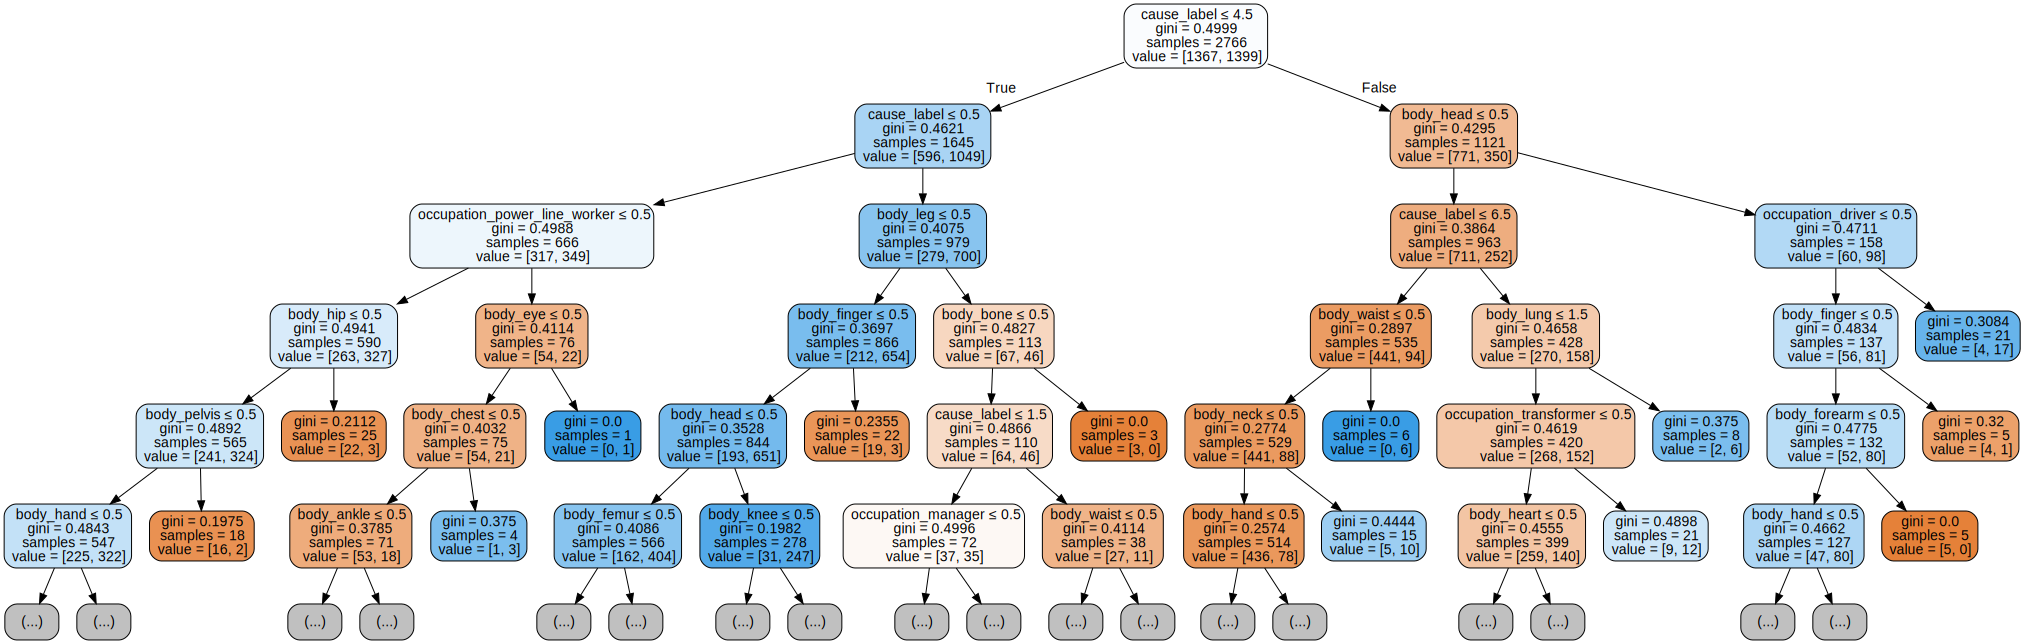

In [10]:
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                max_depth=5, filled=True, 
                                feature_names=X_test.columns, 
                                rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [11]:
# save dot data
tree.export_graphviz(dt_clf, max_depth=6, filled=True, 
                     feature_names=X_test.columns, 
                     rounded=True, out_file='decision_tree.dot')

In [12]:
#Rule induction:

#Rule1: IF ("cause_label"==5 || "cause_label"==6) && !(body_head), 
#       THEN !(is_fatal) ;# possibility: 441/535 = 82.43%

#Rule2: IF ("cause_label"==5 || "cause_label"==6) && !(body_head) && !(body_waist), 
#       THEN !(is_fatal) ;# possibility: 441/529 = 83.36%

#Rule3: IF ("cause_label>=0.5 && "cause_label"<=4.5),
#       THEN (is_fatal)  ;# possibility: 700/979 = 71.50%